<a href="https://colab.research.google.com/github/milosbozic/ml-conference-workshop/blob/master/ml_conferece_wokshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

To activate GPU device, go to **Runtime** -> **Change runtime type**  and in popup window under **Hardware accelerator** drop menu select GPU device and save.  
To check is GPU device avaible, run code below.

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Check what they gave us for free :)

In [3]:
! nvidia-smi

Sat May 11 20:39:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |    221MiB / 15079MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# DATA 

## Load and clean data

Data set which we will use is [Individual household electric power consumption Data Set](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) .  
We have to get data and we can download our dataset and unzip it using a couple of bash commands:

In [4]:
! mkdir data && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip && unzip household_power_consumption.zip -d data/

--2019-05-11 20:39:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip’

household_power_con 100%[===================>]  19.68M  22.4MB/s    in 0.9s    

2019-05-11 20:40:01 (22.4 MB/s) - ‘household_power_consumption.zip’ saved [20640916/20640916]

Archive:  household_power_consumption.zip
  inflating: data/household_power_consumption.txt  


Check is file downloaded and unziped. List folder content:

In [5]:
! ls data/
! head data/household_power_consumption.txt

household_power_consumption.txt
Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000
16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000
16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000
16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000
16/12/2006;17:28:00;3.666;0.528;235.680;15.800;0.000;1.000;17.000
16/12/2006;17:29:00;3.520;0.522;235.020;15.000;0.000;2.000;17.000
16/12/2006;17:30:00;3.702;0.520;235.090;15.800;0.000;1.000;17.000
16/12/2006;17:31:00;3.700;0.520;235.220;15.800;0.000;1.000;17.000
16/12/2006;17:32:00;3.668;0.510;233.990;15.800;0.000;1.000;17.000


When we have out data set local we can import it using pandas. 

In [6]:
import pandas as pd

data = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
#print(data.head())
heder = list(data)
print(heder)
print(data.shape)


['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
(2075259, 7)


Now let's check is there any non numeric or missing values  and how many.

In [7]:
print(data.isnull().sum())

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


On this way we can only check are Nan values in data frame, but because we didn't set NaN values string array in read_csv method, initialy we can only catch default NaN strings like "nan", "Nan", but not others strings like "?" or "-"

In [8]:
missing_values = ["?"]
data = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'], na_values = missing_values)
data = data.astype('float32')
print(data.isnull().sum())

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


When we find all missing values and mark them as NaN, let's fill them somehow.

In [9]:
import numpy as np

def fill_NaN(values, hist):
  one_day = 60 * 24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if np.isnan(values[row, col]):
        hist_values = []
        for k in range(1, hist+1):
          hist_values.append(values[row - one_day*k, col])
        values[row, col] = np.array(hist_values).mean()
 
# fill missing
fill_NaN(data.values, 2)

# Check again is there missing values
print(data.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


## Prepare data for modeling

In [10]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


Our data is power consumption measured per minute frequency, but we are more interested in hourly or daily values. Because of that we have to resample data to get daily values and we can use pandas [***resample()***](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) function with appropriate argument to do it.

In [11]:
data_daily = data.resample('D').mean()
data_daily.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243759,13.082829,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087021,9.999028,1.411806,2.907639,9.264584
2006-12-18,1.530435,0.112356,241.231689,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308060,6.467361,0.000000,1.838889,9.765972


Let's plot original data and our resampled data.

Text(0.5, 1.0, 'Daily resampled data')

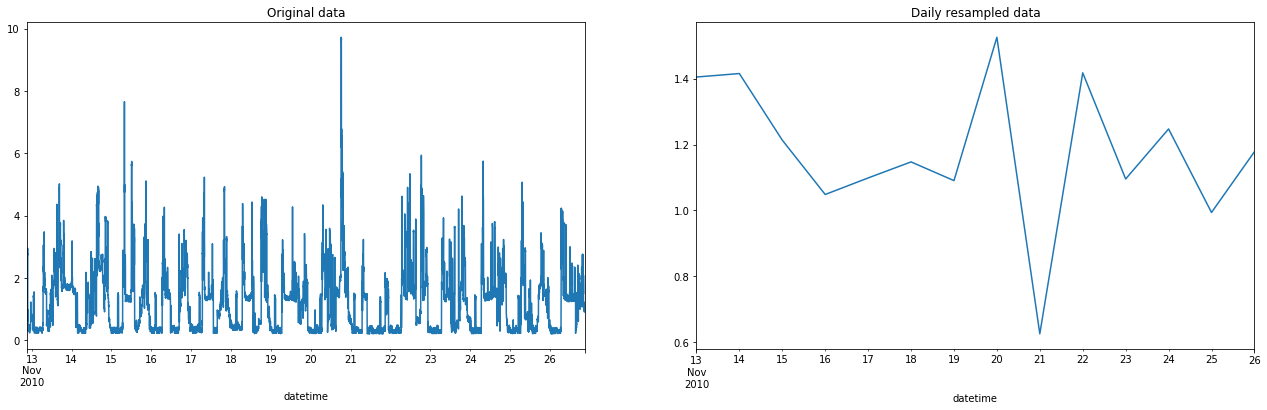

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
data['Global_active_power'].tail(14*60*24).plot(ax=axes[0], subplots=True, x='time', y='active_power', legend=False)
axes[0].set_title('Original data')
data_daily['Global_active_power'].tail(14).plot(ax=axes[1], subplots=True, x='time', y='active_power', legend=False)
axes[1].set_title('Daily resampled data')

Split resampled data to train and test subsets.

In [13]:
data_daily.tail()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-22,1.417733,0.098857,240.197113,6.014167,3.371528,1.465278,7.038889
2010-11-23,1.095511,0.095451,240.575531,4.674445,1.299306,0.318056,5.285417
2010-11-24,1.247394,0.091986,240.030960,5.249583,0.761111,1.977778,8.488889
2010-11-25,0.993864,0.080644,241.536255,4.169445,0.747222,0.295833,3.522222
2010-11-26,1.178230,0.095666,240.291031,4.956295,0.855107,0.304830,7.908947


In [14]:
train_start = '2006-12-16'
train_end = '2010-10-31'
test_start = '2010-11-01'
test_end = '2010-11-26'

train_mask = pd.date_range(train_start, train_end, freq='D')
test_mask = pd.date_range(test_start, test_end, freq='D')
#print(train_mask)
#print(test_mask)

train = data_daily.loc[train_mask]
test = data_daily.loc[test_mask]

train.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-10-27,0.875193,0.106828,246.108704,3.622917,0.000000,1.429167,5.742361
2010-10-28,1.016199,0.130028,246.253891,4.200139,0.765972,1.824306,6.310417
2010-10-29,0.836404,0.135917,245.743103,3.511945,0.746528,0.504167,2.715972
2010-10-30,1.494931,0.135639,243.267365,6.229028,1.634028,0.426389,10.627084
2010-10-31,1.025299,0.144501,245.495285,4.235139,0.993056,0.470833,3.881250


In [15]:
test.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-11-01,0.960542,0.129921,246.379593,3.937639,0.000000,0.440278,6.073611
2010-11-02,0.827140,0.129528,245.786911,3.421806,0.000000,0.398611,4.016667
2010-11-03,0.898124,0.122406,244.278534,3.759583,0.709028,0.769444,4.534028
2010-11-04,1.774407,0.175304,243.152222,7.496111,4.186806,7.772917,7.143055
2010-11-05,1.205617,0.125346,243.775040,5.053333,0.000000,0.548611,8.756945


# Modeling

## Make sequence input

An LSTM model expects input data to have the shape:  [samples, timesteps, features]  

**Univariate with one or multi-steps time series**

In [0]:
# univariate sequence to input samples
def univariate_split(sequence, timesteps, horizon):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + timesteps
    out_end_ix = end_ix + horizon
    #check if we are beyond the sequence
    if out_end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Let's test our function.

In [38]:
# make simple test sequence
in_seq = np.arange(0, 200, 10)
#print(raw_seq)

# set a number of input time steps
n_steps = 7
# set a number of prediction steps
n_out = 1

# split into samples
X, y = univariate_split(in_seq, n_steps, n_out)

# print
for i in range(len(X)):
	print(X[i], y[i])

[ 0 10 20 30 40 50 60] [70]
[10 20 30 40 50 60 70] [80]
[20 30 40 50 60 70 80] [90]
[30 40 50 60 70 80 90] [100]
[ 40  50  60  70  80  90 100] [110]
[ 50  60  70  80  90 100 110] [120]
[ 60  70  80  90 100 110 120] [130]
[ 70  80  90 100 110 120 130] [140]
[ 80  90 100 110 120 130 140] [150]
[ 90 100 110 120 130 140 150] [160]
[100 110 120 130 140 150 160] [170]
[110 120 130 140 150 160 170] [180]


### Multivariate sequences

* **Multiple input with one or multi-step output time series**

In [0]:
# multivariate sequence into samples
def multivariate_split(sequences, timesteps, horizon):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + timesteps
    out_end_ix = end_ix + horizon - 1
    # check if we are beyond the dataset
    if out_end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Test function

In [51]:
in_seq1 = np.arange(0, 100, 10)
in_seq2 = np.arange(5, 100, 10)
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

#print(dataset)

# set a number of time steps
n_steps = 7
n_out = 1

# split into samples
X, y = multivariate_split(dataset, n_steps, n_out)

# print
for i in range(len(X)):
	print(X[i], y[i])

[[ 0  5]
 [10 15]
 [20 25]
 [30 35]
 [40 45]
 [50 55]
 [60 65]] [125]
[[10 15]
 [20 25]
 [30 35]
 [40 45]
 [50 55]
 [60 65]
 [70 75]] [145]
[[20 25]
 [30 35]
 [40 45]
 [50 55]
 [60 65]
 [70 75]
 [80 85]] [165]
[[30 35]
 [40 45]
 [50 55]
 [60 65]
 [70 75]
 [80 85]
 [90 95]] [185]


* **Multiple parallel with one or multi-step output time series** 

In [0]:
def multivariate_parallel_split(sequences, timesteps, horizon):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + timesteps
    out_end_ix = end_ix + horizon
		# check if we are beyond the dataset
    if out_end_ix > len(sequences)-1:
      break
		# gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Test function

In [59]:
in_seq1 = np.arange(0, 100, 10)
in_seq2 = np.arange(5, 100, 10)
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

#print(dataset)

# set a number of time steps
n_steps = 3
n_out = 2

X, y = multivariate_parallel_split(dataset, n_steps, n_out)

for i in range(len(X)):
	print(X[i], y[i])

[[ 0  5  5]
 [10 15 25]
 [20 25 45]] [[30 35 65]
 [40 45 85]]
[[10 15 25]
 [20 25 45]
 [30 35 65]] [[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [[ 70  75 145]
 [ 80  85 165]]
